# Chebyshev and the FFT

We will next explore the interactions between three closely related situations: 

1. Chebyshev series, $x\[-1,1]$.
2. Fourier series, $\theta\in \mathbb{R}$.
3. Laurent series, $z\in \mathbb{C}$, $|z|=1$. 

The relationships between these variables are straightforward. 

$$
z &= e^{i\theta} \\ 
x &= \cos(\theta) \\ 
x &= \operatorname{Re}(z) = \tfrac{1}{2}(z + z^{-1}). 
$$

::::{prf:definition} Chebyshev polynomial
$$
T_n(x) = \tfrac{1}{2}(z^n + z^{-n}) = \cos(n\theta). 
$$
::::

The definition alone does not make it clear that $T_n$ is a polynomial beyond the trivial $T_0(x)=1$ and $T_1(x)=x$. But consider that

$$
\tfrac{1}{2}(z^{n+1} + z^{-n-1})  = \tfrac{1}{2}(z^n + z^{-n}) (z+z^{-1}) - \tfrac{1}{2}(z^{n-1} + z^{-n+1}), 
$$

which proves

$$
T_{n+1}(x) = 2x T_n(x) - T_{n-1}(x), \qquad n=1,2,\dots. 
$$

Therefore, each $T_n$ is a polynomial of degree $n$ with leading coefficient $2^{n-1}$. Each Chebyshev polynomial represents even oscillation around the circle but projects down to oscillations pushed out toward the boundaries of $[-1,1]$:

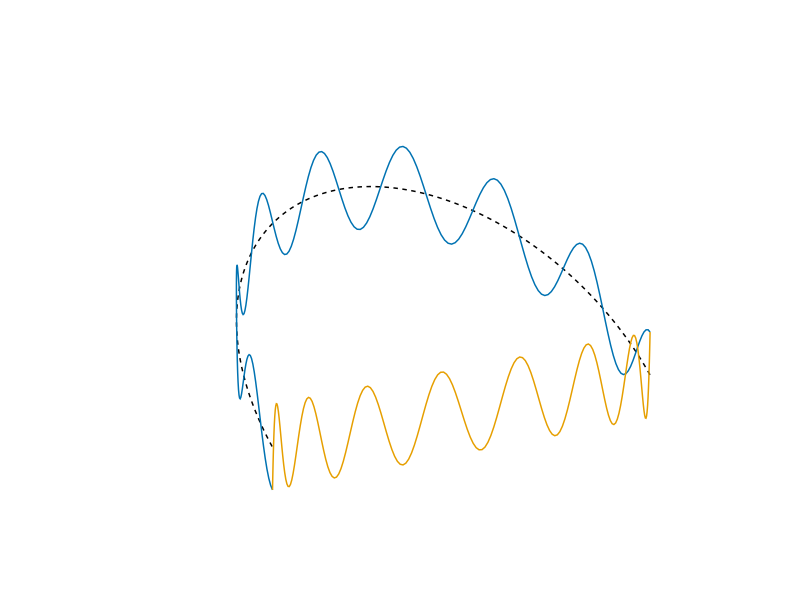

In [1]:
using CairoMakie
fig = Figure(); ax = Axis3(fig[1, 1])
θ = π*(0:200)/200
lines!(cos.(θ),sin.(θ),0*θ,color=:black,linestyle=:dash)
lines!(cos.(θ),sin.(θ),cos.(15θ))
lines!(cos.(θ),0*θ,cos.(15θ))
ax.elevation = 0.2π
ax.azimuth = 1.4π
ax.limits = (-1,1,0,1,-2.5,2.5)
hidedecorations!(ax)
hidespines!(ax)
fig

## Chebyshev series

Any polynomial of degree $N$ can be written as a combination of the first $N+1$ Chebyshev polynomials,

$$
p(x) = \sum_{n=0}^N a_n T_n(x).
$$

Equivalently, we have a **Laurent polynomial**,

$$
\breve{p}(z) = \frac{1}{2} \sum_{n=0}^N a_n (z^n + z^{-n}),
$$

and a trigonometric polynomial,

$$
\tilde{p}(\theta) = \sum_{n=0}^N a_n \cos(n\theta). 
$$

These are all identical:

$$
p(x) = \breve{p}(z) = \tilde{p}(\theta), 
$$

when the three variables are related as we have set out. In the limit $N\to \infty$, each variant becomes an infinite series.

We are interested in using the connections when all the versions of $p$ interpolate a given grid function. In particular, if $p$ interpolates a grid function defined at the Chebyshev points in $x$, then $\tilde{p}(\theta)$ interpolates a grid function around the unit circle, where each of the interior points defines two values:

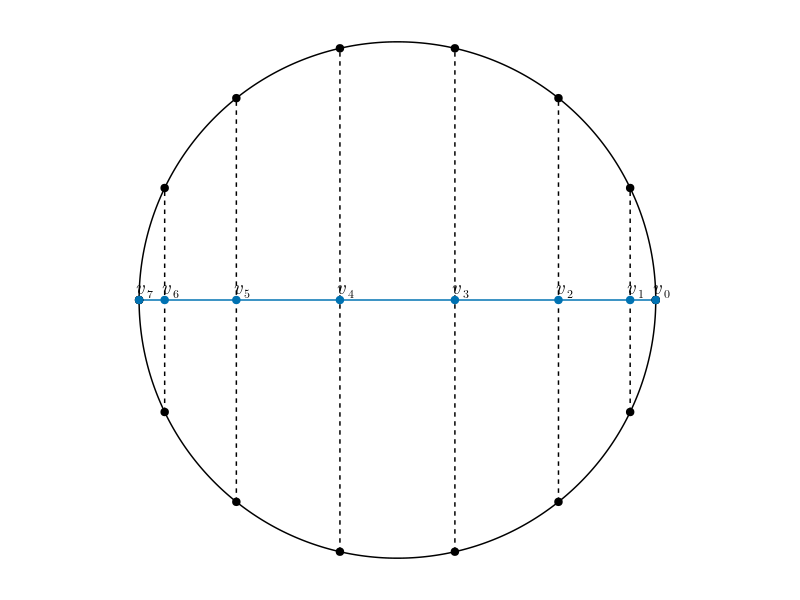

In [2]:
using LaTeXStrings
q = π*(0:800)/400
fig = Figure()
ax = Axis(fig[1, 1], aspect=DataAspect())
lines!(cos.(q),sin.(q),color=:black)
lines!([-1,1],[0,0])
θ = π*(0:7)/7
z = cis.(θ)
x = real(z)
[scatterlines!([x,x],[-imag(z),imag(z)],color=:black,linestyle=:dash) for (x,z) in zip(x,z)]
scatter!(x,0*x)
labels = [ latexstring("v_$j") for j in 0:7 ]
text!(x .+ 0.02, 0*x, text=labels, align=(:center,:bottom) )

hidedecorations!(ax)
hidespines!(ax)
fig

The function $[v_0,v_1,\dots,v_N,v_{N-1},\dots,v_1]$ is even in $\theta$, which is why a cosine series is sufficient for $\tilde{p}$. In fact, the DFT of this function gives us the $a_n$ coefficients directly.

In [3]:
using FFTW
N = 7;
θ = π*(0:N)/N
x = @. cos(θ)
v = @. 2cos(2θ) - 3cos(3θ)
vv = [v; v[N:-1:2]]
fft(vv)/N

14-element Vector{ComplexF64}:
  -3.806478941571965e-16 + 0.0im
   5.075305255429287e-16 + 0.0im
      1.9999999999999996 + 0.0im
     -3.0000000000000004 + 0.0im
   5.075305255429287e-16 + 0.0im
 -1.9032394707859825e-16 + 0.0im
  1.2688263138573217e-16 + 0.0im
                     0.0 + 0.0im
  1.2688263138573217e-16 + 0.0im
 -1.9032394707859825e-16 + 0.0im
   5.075305255429287e-16 + 0.0im
     -3.0000000000000004 + 0.0im
      1.9999999999999996 + 0.0im
   5.075305255429287e-16 + 0.0im

The symmetries in both the data and the transform allow saving space and time by computing only the even (cosine) part by a special syntax:

In [4]:
FFTW.r2r(v,FFTW.REDFT00) / N

8-element Vector{Float64}:
 -3.806478941571965e-16
  4.440892098500626e-16
  1.9999999999999996
 -3.0
  6.026924990822279e-16
 -2.5376526277146434e-16
  1.2688263138573217e-16
  0.0

## Differentiation

We now have a new algorithmic path for Chebyshev spectral differentiation. By the chain rule,

$$
\frac{dp}{dx} = \frac{d\tilde{p}}{d\theta} \cdot \frac{1}{-\sin(\theta)}. 
$$

At $x=\pm 1$, we have $\sin(\theta)=0$ and need to apply L'Hôpital's rule to get

$$
p'(1) = \sum_{n=0}^N n^2 a_n, \qquad p'(-1) = \sum_{n=0}^N (-1)^{n+1} n^2 a_n.
$$

For the second derivative, one finds

$$
{p}''(x) = \frac{-x}{(1-x^2)^{3/2}} \tilde{p}'(\theta) + \frac{1}{1-x^2}\tilde{p}''(\theta), 
$$

except at the endpoints, where special formulas are needed again.